# Scenario 1

All validators offer the same commission, delegators look for best yield.

*Prediction: low-stake, high-engagement validators benefit the most over time relative to other validators, but all do worse with delegation than without.*

In [1]:
from cadCAD import configs
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionContext, ExecutionMode, Executor
import copy
import math
import matplotlib.pyplot as plt
import random

import poe
import pos
import utils

%matplotlib inline

## Model

In [2]:
# network parameters
consensus_algorithms = ['PoS', 'PoE']
default_inflation_rate = 1_000_000

# validator parameters
n_validators = 20
default_commission_rate = 0.2
default_self_stake_base = 0.7
default_self_stake_max = 4_000_000
fixed_cost = 10_000
default_engagement_base = 0.7
default_engagement_max = 10_000
default_f = poe.default_sigmoidal

# delegator parameters
n_delegators = 10
delegation_stake_multiple = 3
default_delegation_rate = 0.1
default_delegation_threshold = 0.02
default_redelegation_threshold = 0.005

# simulation parameters
n_timesteps = 40
n_runs = 1

In [3]:
validators = utils.create_validators(n_validators, default_commission_rate, default_self_stake_base, default_self_stake_max, default_engagement_base, default_engagement_max)
validators_pre = copy.deepcopy(validators)
delegators = utils.create_delegators(n_delegators, validators, delegation_stake_multiple)
initial_state = {
    'delegators': delegators,
    'validators': validators,
}

In [4]:
def should_redelegate(delegator, validators, hypothetical_yield, params):
    delegation_rate = params['delegation_rate']
    delegation_threshold = params['delegation_threshold']
    redelegation_threshold = params['redelegation_threshold']
    current_validator_index = delegator['validator']
    
    if random.random() >= delegation_rate:
        return False
    if current_validator_index is None:
        return hypothetical_yield >= delegation_threshold
    
    total_voting_weight = utils.calculate_total_voting_weight(validators, params)
    current_yield = utils.calculate_yield(validators[current_validator_index], total_voting_weight, params)
    return hypothetical_yield >= redelegation_threshold + current_yield

In [5]:
def redelegate(params, step, history, current_state):
    delegators = copy.deepcopy(current_state['delegators'])
    validators = copy.deepcopy(current_state['validators'])
    
    hypothetical_yields_all = [
        [
            utils.hypothesize_yield(delegator, i, copy.deepcopy(validators), params) for i in range(len(validators))
        ] for delegator in delegators
    ]
    max_hypothetical_yields_all = [max(hypothetical_yields) for hypothetical_yields in hypothetical_yields_all]
    max_validator_indices_all = [
        [
            i for i, hypothetical_yield in enumerate(hypothetical_yields) if hypothetical_yield == max_hypothetical_yield
        ] for hypothetical_yields, max_hypothetical_yield in zip(hypothetical_yields_all, max_hypothetical_yields_all)
    ]
    max_validator_indices = [random.choice(max_validator_indices) for max_validator_indices in max_validator_indices_all]
    validator_indices = [
        max_validator_index
            if should_redelegate(delegator, validators, max_hypothetical_yield, params)
            else delegator['validator']
        for delegator, max_validator_index, max_hypothetical_yield in zip(delegators, max_validator_indices, max_hypothetical_yields_all)
    ]

    return {
        'type': 'redelegate',
        'validator_indices': validator_indices,
    }

In [6]:
def update_delegators(params, step, history, current_state, action):
    delegators = copy.deepcopy(current_state['delegators'])
    validator_indices = action['validator_indices']
    
    if action['type'] != 'redelegate':
        return 'delegators', delegators
    
    for i, delegator in enumerate(delegators):
        delegator['validator'] = validator_indices[i]
        
    return 'delegators', delegators

In [7]:
def update_validators(params, step, history, current_state, action):
    delegators = copy.deepcopy(current_state['delegators'])
    validators = copy.deepcopy(current_state['validators'])
    validator_indices = action['validator_indices']
    
    if action['type'] != 'redelegate':
        return 'validators', validators
    
    for i, validator in enumerate(validators):
        self_stake = validator['self_stake']
        engagement = validator['engagement']
        delegators_for_validator = [delegator for j, delegator in zip(validator_indices, delegators) if i == j]
        delegation = sum([delegator['delegation'] for delegator in delegators_for_validator])
        validator['delegation'] = delegation
    
    return 'validators', validators

## Simulation

In [8]:
partial_state_update_blocks = [
    {
        'policies': {
            'redelegate': redelegate,
        },
        'variables': {
            'delegators': update_delegators,
            'validators': update_validators,
        },
    },
]

In [9]:
parameters = {
    'inflation_rate': [default_inflation_rate],
    'delegation_rate': [default_delegation_rate],
    'delegation_threshold': [default_delegation_threshold],
    'redelegation_threshold': [default_redelegation_threshold],
    'f': [default_f],
    'consensus_algorithm': consensus_algorithms,
}

simulation_config = config_sim({
    'T': range(n_timesteps),
    'N': n_runs,
    'M': parameters,
})

In [10]:
experiment = Experiment()
experiment.append_configs(
    sim_configs=simulation_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

execution_mode = ExecutionMode()
execution_context = ExecutionContext(execution_mode.local_mode)
executor = Executor(execution_context, configs)

In [11]:
raw_result, _, __ = executor.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (40, 6, 2, 2)
Execution Method: local_simulations
SimIDs   : [0, 0]
SubsetIDs: [0, 1]
Ns       : [0, 1]
ExpIDs   : [0, 0]
Execution Mode: parallelized
Total execution time: 1.94s


## Analysis

In [12]:
params_pos = {
    'consensus_algorithm': 'PoS',
    'inflation_rate': default_inflation_rate,
}
params_poe = {
    'consensus_algorithm': 'PoE',
    'inflation_rate': default_inflation_rate,
    'f': default_f,
}

In [13]:
results_per_experiment = 1 + n_timesteps # includes initial state
results_pos = raw_result[:results_per_experiment]
results_poe = raw_result[results_per_experiment:]

validators_result_pos = [result['validators'] for result in results_pos]
validators_result_poe = [result['validators'] for result in results_poe]

voting_weights_pos = [[utils.calculate_voting_weight(validators[i], params_pos) for validators in validators_result_pos] for i in range(n_validators)]
voting_weights_poe = [[utils.calculate_voting_weight(validators[i], params_poe) for validators in validators_result_poe] for i in range(n_validators)]

delegations_pos = [[validators[i]['delegation'] for validators in validators_result_pos] for i in range(n_validators)]
delegations_poe = [[validators[i]['delegation'] for validators in validators_result_poe] for i in range(n_validators)]

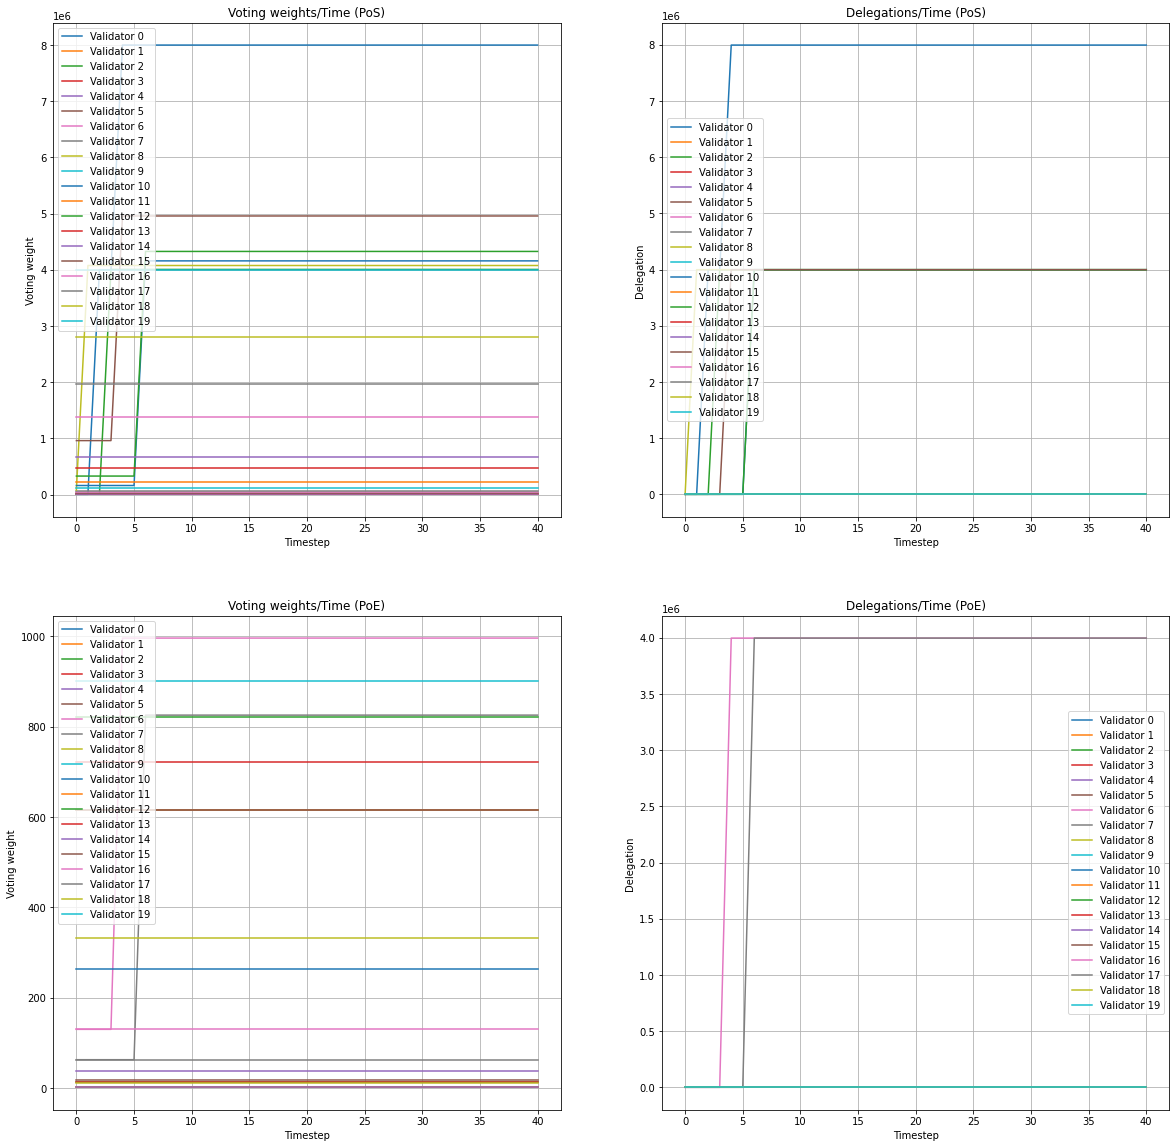

In [14]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Voting weights/Time (PoS)')
plt.xlabel('Timestep')
plt.ylabel('Voting weight')
for i, voting_weight in enumerate(voting_weights_pos):
    plt.plot(voting_weight, label=(f"Validator %i" % i))
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Delegations/Time (PoS)')
plt.xlabel('Timestep')
plt.ylabel('Delegation')
for i, delegation in enumerate(delegations_pos):
    plt.plot(delegation, label=(f"Validator %i" % i))
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.title('Voting weights/Time (PoE)')
plt.xlabel('Timestep')
plt.ylabel('Voting weight')
for i, voting_weight in enumerate(voting_weights_poe):
    plt.plot(voting_weight, label=(f"Validator %i" % i))
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.title('Delegations/Time (PoE)')
plt.xlabel('Timestep')
plt.ylabel('Delegation')
for i, delegation in enumerate(delegations_poe):
    plt.plot(delegation, label=(f"Validator %i" % i))
plt.grid()
plt.legend()

plt.show()

In [15]:
engagements = [validator['engagement'] for validator in validators_pre]

validators_post_pos = validators_result_pos[-1]
validators_post_poe = validators_result_poe[-1]

voting_weights_pre_pos = [utils.calculate_voting_weight(validator, params_pos) for validator in validators_pre]
voting_weights_pre_poe = [utils.calculate_voting_weight(validator, params_poe) for validator in validators_pre]
voting_weights_post_pos = [utils.calculate_voting_weight(validator, params_pos) for validator in validators_post_pos]
voting_weights_post_poe = [utils.calculate_voting_weight(validator, params_poe) for validator in validators_post_poe]

total_voting_weight_pre_pos = sum(voting_weights_pre_pos)
total_voting_weight_pre_poe = sum(voting_weights_pre_poe)
total_voting_weight_post_pos = sum(voting_weights_post_pos)
total_voting_weight_post_poe = sum(voting_weights_post_poe)

profits_pre_pos = [utils.calculate_reward(validator, total_voting_weight_pre_pos, params_pos) - fixed_cost for validator in validators_pre]
profits_pre_poe = [utils.calculate_reward(validator, total_voting_weight_pre_poe, params_poe) - fixed_cost for validator in validators_pre]
profits_post_pos = [utils.calculate_reward(validator, total_voting_weight_post_pos, params_pos) - fixed_cost for validator in validators_post_pos]
profits_post_poe = [utils.calculate_reward(validator, total_voting_weight_post_poe, params_poe) - fixed_cost for validator in validators_post_poe]

In [16]:
default_alt_color = "#ff7f0e"

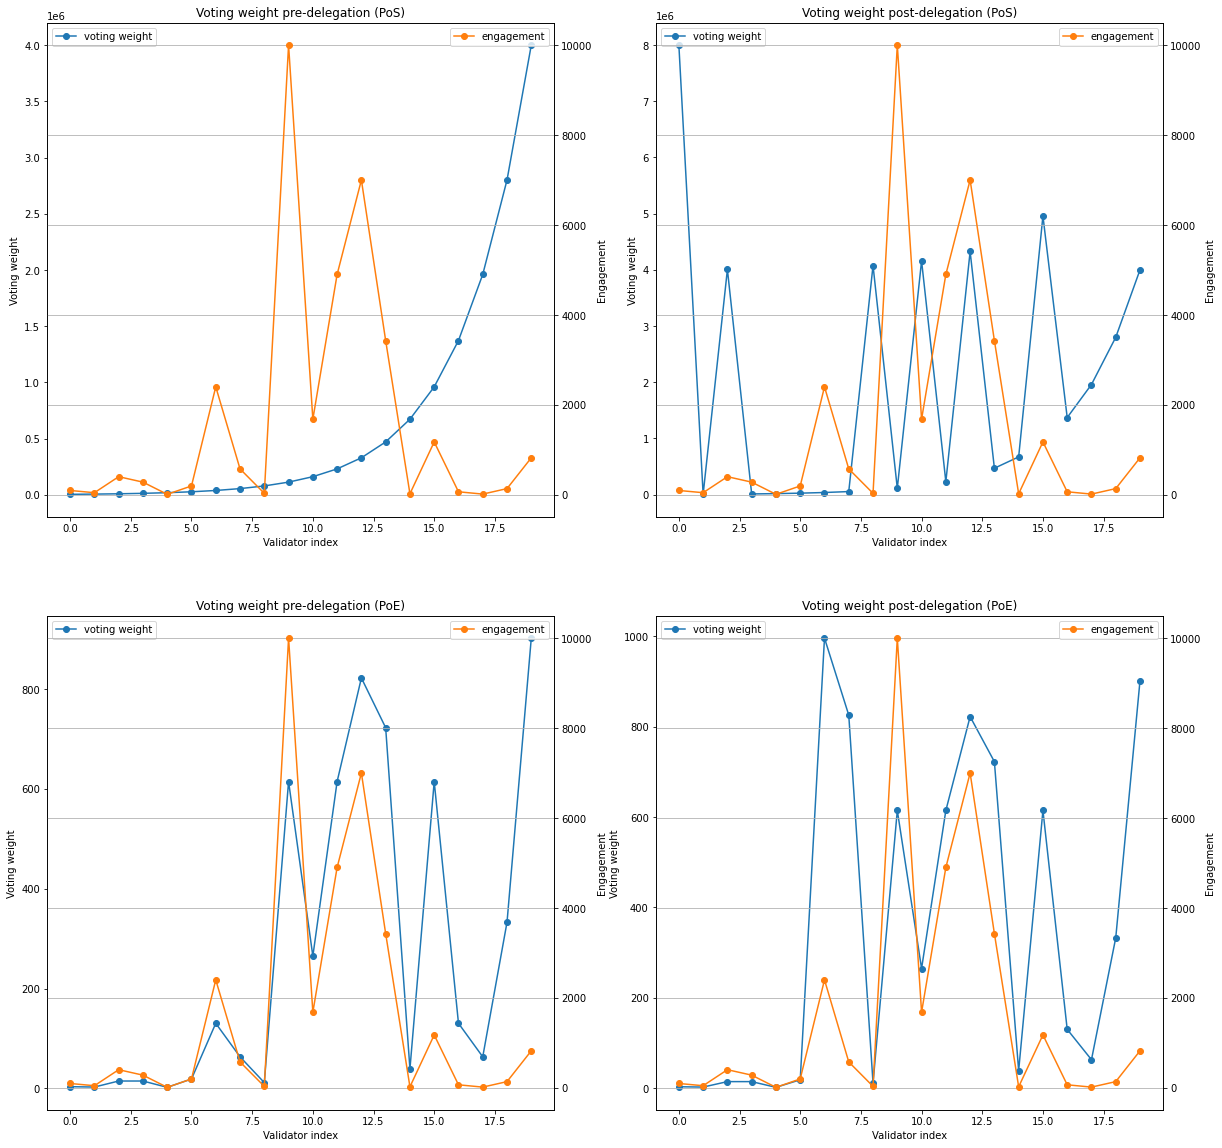

In [17]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Voting weight pre-delegation (PoS)')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.plot(voting_weights_pre_pos, marker='o', label="voting weight")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)
plt.grid()

plt.subplot(2, 2, 2)
plt.title('Voting weight post-delegation (PoS)')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.plot(voting_weights_post_pos, marker='o', label="voting weight")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)
plt.grid()

plt.subplot(2, 2, 3)
plt.title('Voting weight pre-delegation (PoE)')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.plot(voting_weights_pre_poe, marker='o', label="voting weight")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)
plt.grid()

plt.subplot(2, 2, 4)
plt.title('Voting weight post-delegation (PoE)')
plt.xlabel('Validator index')
plt.ylabel('Voting weight')
plt.plot(voting_weights_post_poe, marker='o', label="voting weight")
plt.legend(loc=2)
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)
plt.grid()

plt.show()

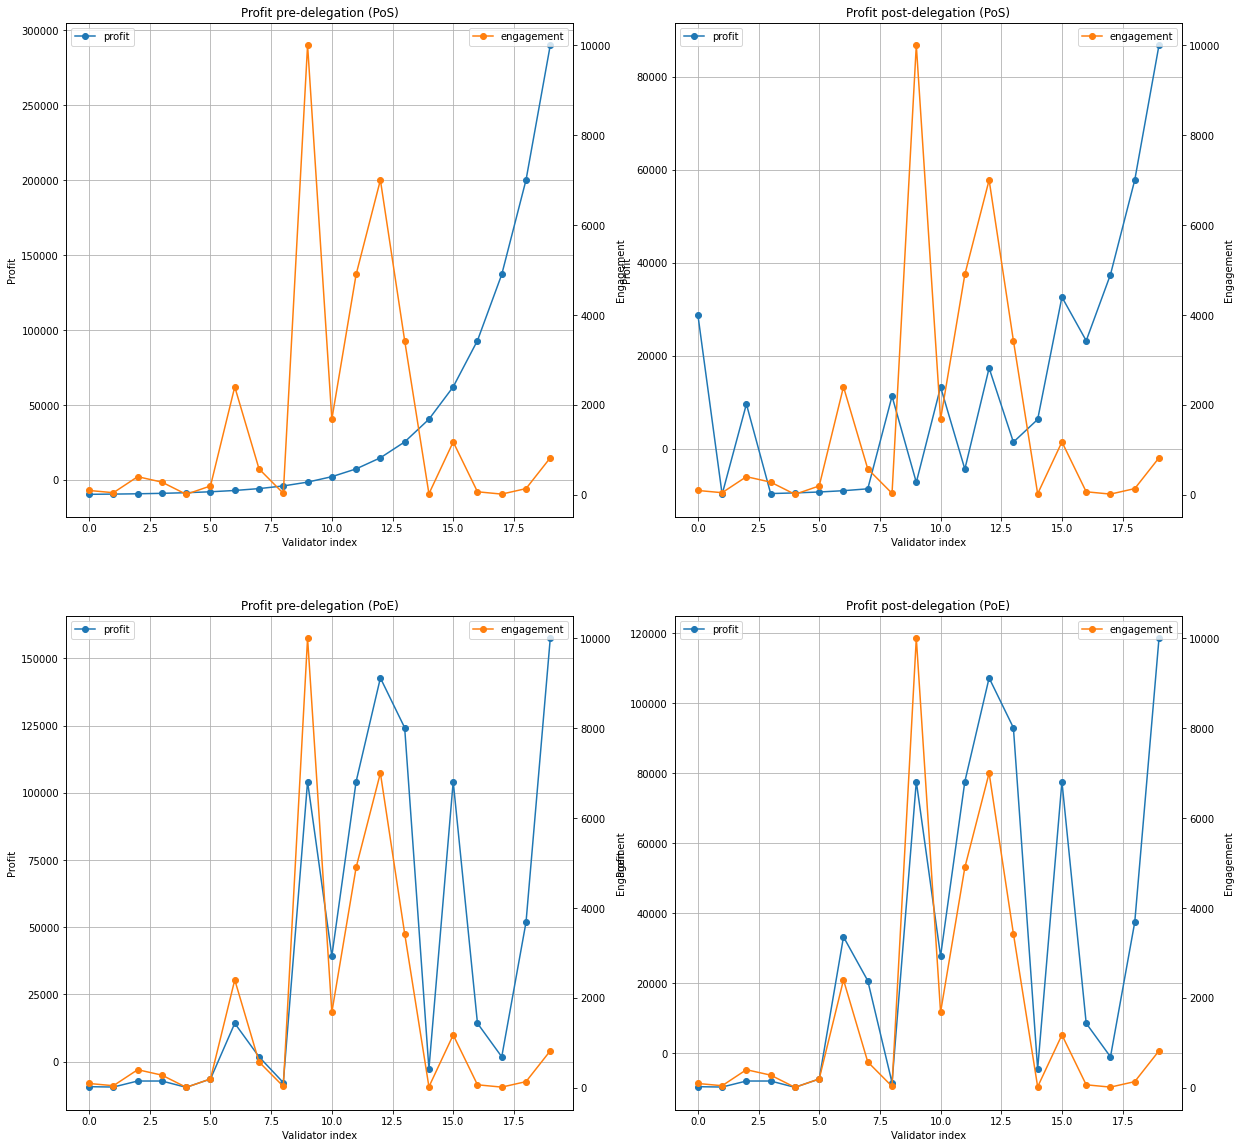

In [18]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Profit pre-delegation (PoS)')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.plot(profits_pre_pos, marker='o', label="profit")
plt.legend(loc=2)
plt.grid()
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)

plt.subplot(2, 2, 2)
plt.title('Profit post-delegation (PoS)')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.plot(profits_post_pos, marker='o', label="profit")
plt.legend(loc=2)
plt.grid()
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)

plt.subplot(2, 2, 3)
plt.title('Profit pre-delegation (PoE)')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.plot(profits_pre_poe, marker='o', label="profit")
plt.legend(loc=2)
plt.grid()
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)

plt.subplot(2, 2, 4)
plt.title('Profit post-delegation (PoE)')
plt.xlabel('Validator index')
plt.ylabel('Profit')
plt.plot(profits_post_poe, marker='o', label="profit")
plt.legend(loc=2)
plt.grid()
plt.twinx()
plt.ylabel('Engagement')
plt.plot(engagements, marker='o', color=default_alt_color, label="engagement")
plt.legend(loc=1)

plt.show()

In [19]:
gini_coefficient_voting_weights_pre_pos = utils.calculate_gini_coefficient(voting_weights_pre_pos)
gini_coefficient_voting_weights_post_pos = utils.calculate_gini_coefficient(voting_weights_post_pos)
gini_coefficient_profits_pre_pos = utils.calculate_gini_coefficient(profits_pre_pos)
gini_coefficient_profits_post_pos = utils.calculate_gini_coefficient(profits_post_pos)

print("PoS Gini coefficients")
print(f'Voting weights pre-delegation: %f' % gini_coefficient_voting_weights_pre_pos)
print(f'Voting weights post-delegation: %f' % gini_coefficient_voting_weights_post_pos)
print(f'Profits pre-delegation: %f' % gini_coefficient_profits_pre_pos)
print(f'Profits post-delegation: %f' % gini_coefficient_profits_post_pos)

print("")

gini_coefficient_voting_weights_pre_poe = utils.calculate_gini_coefficient(voting_weights_pre_poe)
gini_coefficient_voting_weights_post_poe = utils.calculate_gini_coefficient(voting_weights_post_poe)
gini_coefficient_profits_pre_poe = utils.calculate_gini_coefficient(profits_pre_poe)
gini_coefficient_profits_post_poe = utils.calculate_gini_coefficient(profits_post_poe)

print("PoE Gini coefficients")
print(f'Voting weights pre-delegation: %f' % gini_coefficient_voting_weights_pre_poe)
print(f'Voting weights post-delegation: %f' % gini_coefficient_voting_weights_post_poe)
print(f'Profits pre-delegation: %f' % gini_coefficient_profits_pre_poe)
print(f'Profits post-delegation: %f' % gini_coefficient_profits_post_poe)

PoS Gini coefficients
Voting weights pre-delegation: 0.718264
Voting weights post-delegation: 0.580371
Profits pre-delegation: 0.897830
Profits post-delegation: 1.013639

PoE Gini coefficients
Voting weights pre-delegation: 0.606058
Voting weights post-delegation: 0.557821
Profits pre-delegation: 0.757572
Profits post-delegation: 0.764707


In [20]:
delegators_post_pos = results_pos[-1]['delegators']
delegators_post_poe = results_poe[-1]['delegators']

n_staking_delegators_pos = len([delegator for delegator in delegators_post_pos if delegator['validator'] is not None])
n_staking_delegators_poe = len([delegator for delegator in delegators_post_poe if delegator['validator'] is not None])
percent_staking_delegators_pos = n_staking_delegators_pos * 100 / n_delegators
percent_staking_delegators_poe = n_staking_delegators_poe * 100 / n_delegators

print(f'Delegators staking (PoS): %d%%' % percent_staking_delegators_pos)
print(f'Delegators staking (PoE): %d%%' % percent_staking_delegators_poe)

Delegators staking (PoS): 70%
Delegators staking (PoE): 20%


## Conclusions

- Yield-seeking delegators push voting weights in the direction of more equality.
- Yield-seeking delegators make profits slightly less equal across validators.
- Most validators have lower profits after delegation. High-stake, low-engagement validators lose the most profit, and the biggest winners are validators with very low stake but high engagement.